In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

In [2]:
pd.set_option('max_columns', None)

In [3]:
train = pd.read_csv('../input/playground-series-s3e3/train.csv').drop('id', axis=1)
orig = pd.read_csv('../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
test = pd.read_csv('../input/playground-series-s3e3/test.csv').drop('id', axis=1)

orig = orig[list(train.columns)]

train_all = pd.concat([train,orig], axis=0)\
              .reset_index(drop=True)
print(train.shape, orig.shape, test.shape, train_all.shape)

(1677, 34) (1470, 34) (1119, 33) (3147, 34)


# Data Processing

In [4]:
class data_processor:
    def __init__(self):
        self.scaler = None
        
    def preprocess_data(self, df, train=True):
        # remove Over18
        df = df.drop('Over18', axis=1)
        
        # binary representation
        if train:
            df['Attrition'] = df['Attrition'].replace({'Yes':1,
                                                       'No':0})
        df['OverTime'] = df['OverTime'].replace({'Yes':1,
                                                 'No':0})
        df['Gender'] = df['Gender'].replace({'Male':1,
                                             'Female':0})
        
        # identify categorical columns
        cat_cols = list(df.select_dtypes(include=['object']).columns)
        
        # one_hot_encode
        df = pd.get_dummies(df, columns=cat_cols)

        # LassoCV has standardize argument deprecated
        # so lets do it within standardization step
        scale_cols = [x for x in df.columns if x not in cat_cols+['OverTime','Gender','Attrition']]
        
        if train:
            self.scaler = StandardScaler()
            scaled = self.scaler.fit_transform(df[scale_cols])
        else:
            scaled = self.scaler.transform(df[scale_cols])
        
        df[scale_cols] = scaled
        
        return df

In [5]:
processor = data_processor()
train_all = processor.preprocess_data(train_all, train=True)
test = processor.preprocess_data(test, train=False)

In [6]:
X = train_all.drop('Attrition', axis=1)
y = train_all['Attrition']

# LassoCV

Want to start off with the same approach as Tilii laid out in S3E3
https://www.kaggle.com/code/tilii7/modeling-stroke-dataset-with-lasso-regression

In [7]:
n_folds = 5
n_repeats = 10
total_folds = n_folds*n_repeats
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12345)

In [8]:
%%time
test_preds = np.zeros((len(test),))
oof_preds = np.zeros((len(train_all),))

for i, (train_index, val_index) in enumerate(rkf.split(X, y)):
    print("Fold {}".format(i))
    # split data into train/val
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # train all models
    print('Training LassoCV')
    lasso_cv = LassoCV(precompute="auto",
                       fit_intercept=True,
                       max_iter=10000,
                       verbose=False,
                       eps=1e-04,
                       cv=3,
                       n_alphas=1000,
                       n_jobs=-1)
    lasso_cv.fit(X_train, y_train)
    
    # make predictions
    lasso_train_preds = lasso_cv.predict(X_train)
    lasso_train_preds = 1/(1 + np.exp(-lasso_train_preds))
    lasso_val_preds = lasso_cv.predict(X_val)
    lasso_val_preds = 1/(1 + np.exp(-lasso_val_preds))
    lasso_test_preds = lasso_cv.predict(test)
    lasso_test_preds = 1/(1 + np.exp(-lasso_test_preds))
    
    oof_preds[val_index] += lasso_val_preds/total_folds
    test_preds += lasso_test_preds/total_folds
    
    # print validation score
    val_roc_auc = np.round(roc_auc_score(y_val, lasso_val_preds), 5)
    print("Val ROC AUC: {}".format(val_roc_auc))
    
    print("")
    print("")

oof_auc = np.round(roc_auc_score(y, oof_preds), 5)
print("Overall ROC AUC: {}".format(oof_auc))

Fold 0
Training LassoCV
Val ROC AUC: 0.84357


Fold 1
Training LassoCV
Val ROC AUC: 0.83798


Fold 2
Training LassoCV
Val ROC AUC: 0.82315


Fold 3
Training LassoCV
Val ROC AUC: 0.81965


Fold 4
Training LassoCV
Val ROC AUC: 0.84829


Fold 5
Training LassoCV
Val ROC AUC: 0.82619


Fold 6
Training LassoCV
Val ROC AUC: 0.83604


Fold 7
Training LassoCV
Val ROC AUC: 0.85425


Fold 8
Training LassoCV
Val ROC AUC: 0.83259


Fold 9
Training LassoCV
Val ROC AUC: 0.8114


Fold 10
Training LassoCV
Val ROC AUC: 0.84688


Fold 11
Training LassoCV
Val ROC AUC: 0.84762


Fold 12
Training LassoCV
Val ROC AUC: 0.85026


Fold 13
Training LassoCV
Val ROC AUC: 0.79328


Fold 14
Training LassoCV
Val ROC AUC: 0.81449


Fold 15
Training LassoCV
Val ROC AUC: 0.86746


Fold 16
Training LassoCV
Val ROC AUC: 0.81973


Fold 17
Training LassoCV
Val ROC AUC: 0.80553


Fold 18
Training LassoCV
Val ROC AUC: 0.81384


Fold 19
Training LassoCV
Val ROC AUC: 0.84517


Fold 20
Training LassoCV
Val ROC AUC: 0.78735


Fol

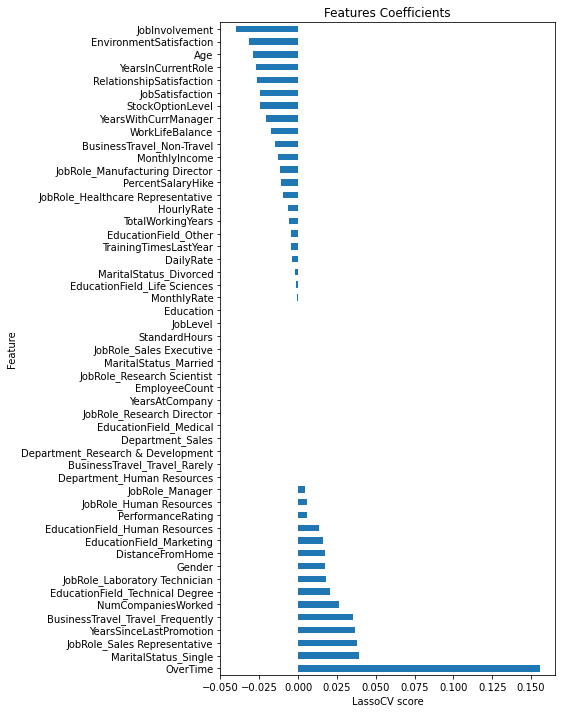

In [9]:
coef = pd.DataFrame(lasso_cv.coef_, columns=["LassoCV_score"])
coef["Feature"] = list(X_train.columns)
coef["Relative score"] = coef["LassoCV_score"] / coef["LassoCV_score"].sum()
coef = coef.sort_values("Relative score", ascending=False)
coef = coef[["Feature", "LassoCV_score", "Relative score"]]

coef.plot(kind="barh", x="Feature", y="LassoCV_score", legend=False, figsize=(6, 12))
plt.title("Features Coefficients")
plt.xlabel("LassoCV score")
plt.show()

# Make Submission

In [10]:
sub = pd.read_csv('../input/playground-series-s3e3/sample_submission.csv')
sub['Attrition'] = lasso_test_preds
sub.to_csv('submission.csv', header=True, index=False)